<a href="https://colab.research.google.com/github/TariqAlhathloul/Time-Series-Forecasting-Project/blob/main/WorkSpace/traffic_Counts_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Description: This dataset includes real-time and historical traffic congestion data from Chicago, including traffic flow, speed, and incident reports. It's valuable for studying traffic patterns in urban environments.

## Dataset Overview

#### 1. `ID`: A unique identifier for each traffic count record.

#### 2. `Traffic Volume Count Location Address`: The address where the traffic volume was recorded.

#### 3. `Street`: The street name where the traffic count was taken.

#### 4. `Date of Count`: The date on which the traffic count was recorded.

#### 5. `Total Passing Vehicle Volume`: The total number of vehicles that passed the location during the count period.

#### 6. ` Vehicle Volume By Each Direction of Traffic`: The vehicle count divided by direction (e.g., East Bound, West Bound).

#### 7. `Latitude`: The latitude coordinate of the traffic count location.

#### 8. `Longitude`: The longitude coordinate of the traffic count location.

#### 9. `Location`: The geographic location as a tuple of latitude and longitude.

Check out the [City of Chicago Traffic Data](https://www.chicago.gov/city/en/depts/cdot/dataset/average_daily_trafficcounts.html) for more information.


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/username/repository/blob/main/notebook.ipynb)

### Change the datatype of the `Date of Count` from object to datetime.
### drop`ID` and `Location`.
### Set new column `Date` as index.
### sort the values in the dataframe based on the `date`.

## Import Libraries.

In [134]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler

import keras

import math
from sklearn.metrics import mean_squared_error

## Load The Data.

In [3]:
df_traffic = pd.read_csv("/content/Average_Daily_Traffic_Counts_-_2006.csv", parse_dates=['Date of Count'])

### Change the datatype of the `Date of Count` from object to datetime.
### drop`ID` and `Location`.
### Set new column `Date` as index.
### sort the values in the dataframe based on the `date`.

In [51]:
df_traffic['Date'] = pd.to_datetime(df_traffic['Date of Count'], format='%m/%d/%Y')
df_traffic = df_traffic.sort_values(by='Date')
df_traffic.set_index('Date', inplace=True)

In [52]:
df_traffic.columns

Index(['Date of Count', 'Total Passing Vehicle Volume', 'Latitude',
       'Longitude'],
      dtype='object')

In [48]:
df_traffic.drop(columns=['ID ', 'Traffic Volume Count Location  Address', 'Street',
                         'Vehicle Volume By Each Direction of Traffic', 'Location'], axis=1, inplace=True)

In [53]:
df_traffic.head()

,Date of Count,Total Passing Vehicle Volume,Latitude,Longitude
Date,,,,
2006-02-01,2006-02-01,21700,41.770685,-87.605711
2006-02-01,2006-02-01,13700,41.797881,-87.606302
2006-02-28,2006-02-28,21600,41.765204,-87.644371
2006-02-28,2006-02-28,16700,41.754187,-87.615027
2006-02-28,2006-02-28,16500,41.765008,-87.657067


In [58]:
def date(df, start, end):
  selected_date = df[ (df['Date of Count'] > start) & (df['Date of Count'] < end) ]
  return pd.DataFrame(data=selected_date, columns=df.columns)

In [56]:
start_date = dt.datetime(2006, 2, 1)
end_date = dt.datetime(2006, 7, 16)

In [59]:
selected_df = date(df_traffic, start_date, end_date)

In [60]:
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 338 entries, 2006-02-28 to 2006-05-11
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date of Count                 338 non-null    datetime64[ns]
 1   Total Passing Vehicle Volume  338 non-null    int64         
 2   Latitude                      338 non-null    float64       
 3   Longitude                     338 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 13.2 KB


## Visualization.

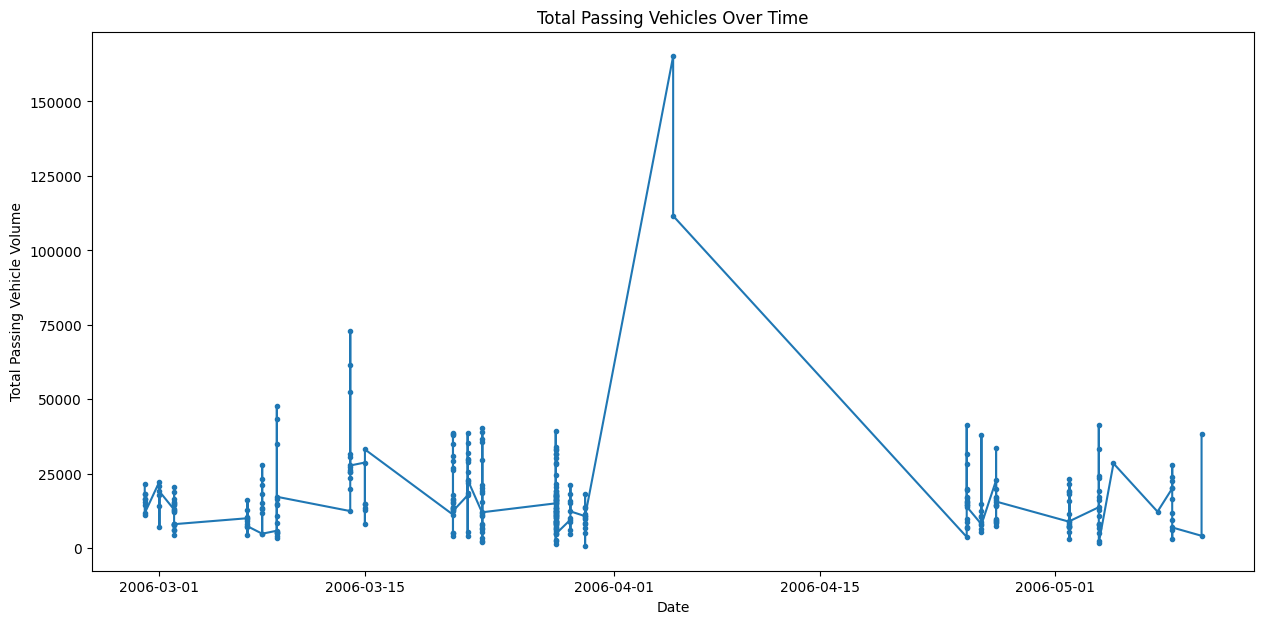

In [61]:
plt.figure(figsize=(15, 7))

plt.plot(selected_df['Date of Count'], selected_df['Total Passing Vehicle Volume'], marker='.')
plt.xlabel('Date')
plt.ylabel('Total Passing Vehicle Volume')
plt.title('Total Passing Vehicles Over Time')
plt.show()

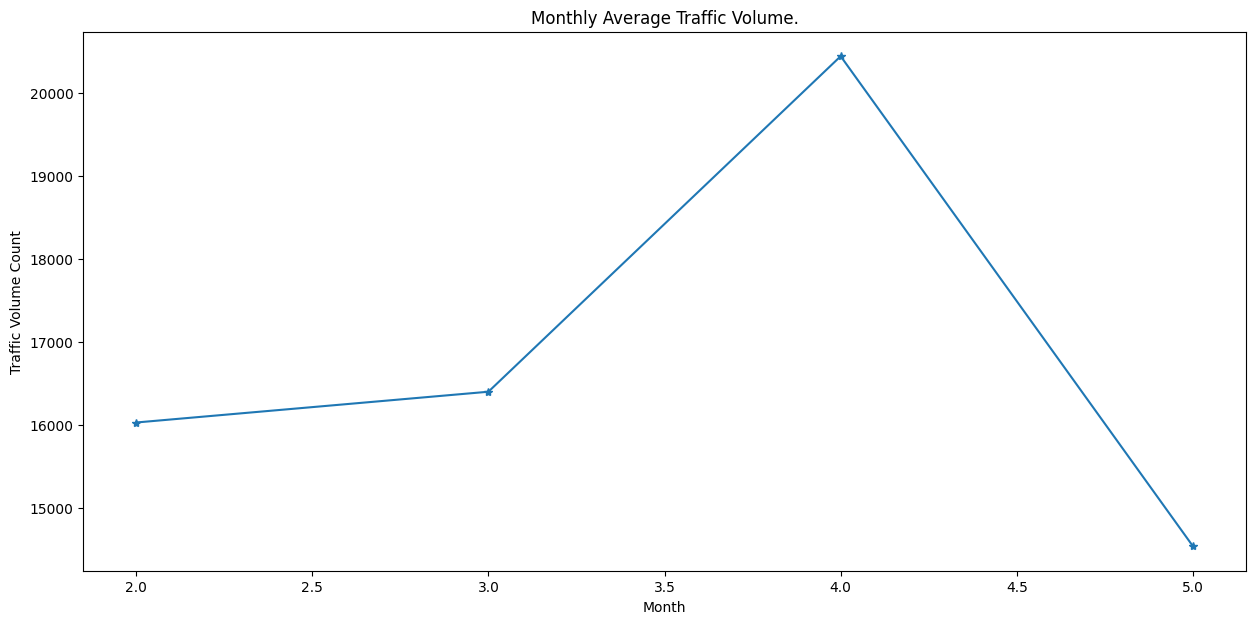

In [63]:
selected_df['Month'] = selected_df['Date of Count'].dt.month
selected_df.set_index('Month', inplace=True)
grouped_average = selected_df.groupby('Month')['Total Passing Vehicle Volume'].mean()

plt.figure(figsize=(15, 7))
plt.plot(grouped_average.index, grouped_average.values, marker='*')
plt.xlabel("Month")
plt.ylabel("Traffic Volume Count")
plt.title("Monthly Average Traffic Volume.")
plt.show()

In [34]:
selected_df.index

Index([2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       ...
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
      dtype='int32', name='Month', length=338)

## Normalize The Data

In [69]:
new_df = selected_df.reset_index()['Total Passing Vehicle Volume']

In [71]:
new_df.head()

,Total Passing Vehicle Volume
0,21600
1,16700
2,16500
3,18200
4,14600


In [74]:
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [90]:
def create_sequences(data, sequence_len):
  X, Y = [], []

  for i in range(sequence_len, len(data)):
    X.append(data[i - sequence_len: i, 0])
    Y.append(data[i, 0])

  return np.array(X), np.array(Y)

In [91]:
seq_len = 30
x, y = create_sequences(scaled_data, sequence_len=seq_len)

In [92]:
train_size = int(0.5 * len(x))
val_size = int(0.25 * len(x))
test_size = len(x) - train_size - val_size

X_train, y_train = x[:train_size], y[:train_size]

X_val, y_val = x[train_size:train_size + val_size], y[train_size:train_size + val_size]

X_test, y_test = x[train_size + val_size:], y[train_size + val_size:]

In [98]:
print(f'X train {X_train.shape}\nX val {X_val.shape}\nX test{X_test.shape}\n')

print(f'y train {y_train.shape}\ny val {y_val.shape}\ny test{y_test.shape}')

X train (154, 30)
X val (77, 30)
X test(77, 30)

y train (154,)
y val (77,)
y test(77,)


## Modeling

In [102]:
%pip install keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [138]:

# Model definition
model = Sequential()

# Explicitly add the Input layer
model.add(Input(shape=(X_train.shape[1], 1)))

# First RNN layer with return_sequences=True
model.add(SimpleRNN(units=32, return_sequences=True))
model.add(Dropout(0.2))

# Second RNN layer
model.add(SimpleRNN(units=64, activation='tanh'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

## Model Summary.

In [139]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)             │ (None, 30, 32)              │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_6 (SimpleRNN)             │ (None, 64)                  │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mape']
)

In [149]:
call_backs = [
    EarlyStopping(monitor='mape', patience=10),
    ModelCheckpoint('Models/Simple_RNN_Model.keras', save_best_only=True)
]

In [150]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size = 8,
    epochs=50,
    callbacks=call_backs,
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0053 - mape: 102.5451 - val_loss: 0.0167 - val_mape: 1480987.1250
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0066 - mape: 111.2663 - val_loss: 0.0189 - val_mape: 1390347.3750
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0045 - mape: 92.2642 - val_loss: 0.0180 - val_mape: 1691019.7500
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0046 - mape: 99.1176 - val_loss: 0.0170 - val_mape: 1472492.5000
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0034 - mape: 75.4575 - val_loss: 0.0174 - val_mape: 1602676.5000
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0046 - mape: 101.3842 - val_loss: 0.0171 - val_mape: 1430769.2500
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0055 - mape: 105.0725 - val_loss: 0.0169 - val_mape: 1610610.7500
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0045 - mape: 98.4058 - val_loss: 0.0161 - val_mape: 1

## predictions

In [152]:
loaded_model = keras.models.load_model('/content/Models/Simple_RNN_Model.keras')

train_pred = loaded_model.predict(X_train)
test_pred = loaded_model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


## Transform the data back to it's original form

In [153]:
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

In [154]:

print(math.sqrt(mean_squared_error(y_train, train_pred)))

print(math.sqrt(mean_squared_error(y_test, test_pred)))

18735.18232700369
17353.763718645114


In [155]:
# Evaluate the model
test_loss, test_mape = model.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mape: 106.5232


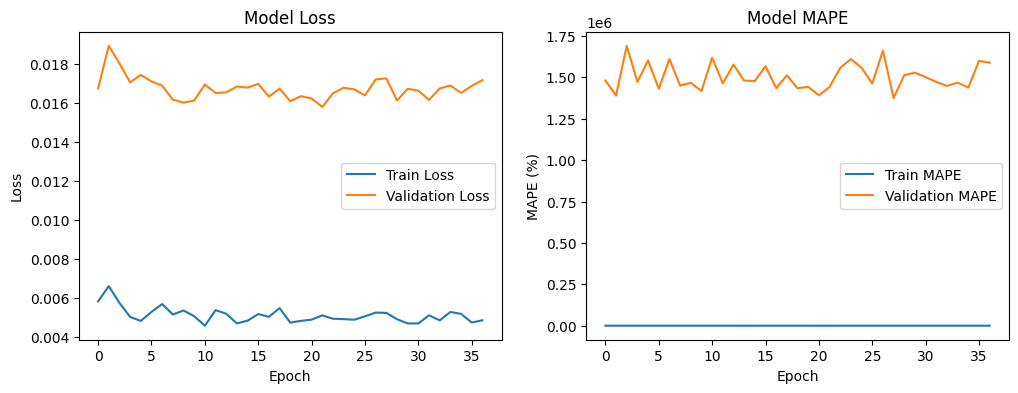

In [156]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation MAPE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='Train MAPE')
plt.plot(history.history['val_mape'], label='Validation MAPE')
plt.title('Model MAPE')
plt.ylabel('MAPE (%)')
plt.xlabel('Epoch')
plt.legend()

plt.show()
